In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='ticks', context='talk')
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point
import fiona
%matplotlib inline

This section joins the watershed shapefile with the 500k geologic map shapefile

In [3]:
#this section is pulled from the geopandas github https://github.com/geopandas/geopandas/issues/400 that speeds up overlay
#this version runs in <3% of the time of the original, which means minutes instead of days for this dataset.
import geopandas as gp

def spatial_overlays(df1, df2, how='intersection'):
    '''Compute overlay intersection of two 
        GeoPandasDataFrames df1 and df2
    '''
    df1 = df1.copy()
    df2 = df2.copy()
    df1['geometry'] = df1.geometry.buffer(0)
    df2['geometry'] = df2.geometry.buffer(0)
    if how=='intersection':
        # Spatial Index to create intersections
        spatial_index = df2.sindex
        df1['bbox'] = df1.geometry.apply(lambda x: x.bounds)
        df1['histreg']=df1.bbox.apply(lambda x:list(spatial_index.intersection(x)))
        pairs = df1['histreg'].to_dict()
        nei = []
        for i,j in pairs.items():
            for k in j:
                nei.append([i,k])
        
        pairs = gp.GeoDataFrame(nei, columns=['idx1','idx2'], crs=df1.crs)
        pairs = pairs.merge(df1, left_on='idx1', right_index=True)
        pairs = pairs.merge(df2, left_on='idx2', right_index=True, suffixes=['_1','_2'])
        pairs['Intersection'] = pairs.apply(lambda x: (x['geometry_1'].intersection(x['geometry_2'])).buffer(0), axis=1)
        pairs = gp.GeoDataFrame(pairs, columns=pairs.columns, crs=df1.crs)
        cols = pairs.columns.tolist()
        cols.remove('geometry_1')
        cols.remove('geometry_2')
        cols.remove('histreg')
        cols.remove('bbox')
        cols.remove('Intersection')
        dfinter = pairs[cols+['Intersection']].copy()
        dfinter.rename(columns={'Intersection':'geometry'}, inplace=True)
        dfinter = gp.GeoDataFrame(dfinter, columns=dfinter.columns, crs=pairs.crs)
        dfinter = dfinter.loc[dfinter.geometry.is_empty==False]
        return dfinter
    elif how=='difference':
        spatial_index = df2.sindex
        df1['bbox'] = df1.geometry.apply(lambda x: x.bounds)
        df1['histreg']=df1.bbox.apply(lambda x:list(spatial_index.intersection(x)))
        df1['new_g'] = df1.apply(lambda x: reduce(lambda x, y: x.difference(y).buffer(0), [x.geometry]+list(df2.iloc[x.histreg].geometry)) , axis=1)
        df1.geometry = df1.new_g
        df1 = df1.loc[df1.geometry.is_empty==False].copy()
        df1.drop(['bbox', 'histreg', new_g], axis=1, inplace=True)
        return df1

In [2]:
huc8=gpd.read_file(r'J:\Geology\WSGS\GIS\huc_12.shp') #reads in the hydraulic basin units and adds an area column
huc8= huc8.to_crs({'init': 'epsg:3732'})
huc8['area']=huc8.area #area in square feet

In [5]:
bedrock=gpd.read_file(r'J:\Geology\WSGS\GIS\bedrock.shp') #reads in the 500k bedrock map
bedrock= bedrock.to_crs({'init': 'epsg:3732'})

In [40]:
overlain=spatial_overlays(bedrock,huc8, how='intersection') #calculates the intersection of bedrock and drainage
overlain['area'] = overlain.area
overlain.to_csv('J:/Geology/WSGS/intersection_huc12.csv')

In [41]:
overlain.columns

Index(['idx1', 'idx2', 'Symbol_Ori', 'Unit_Name', 'Unit_Descr', 'Unit_Age',
       'Symbol', 'RuleID_1', 'Shape_Leng_1', 'Shape_Area_1', 'AREA',
       'PERIMETER', 'WY_HU12_', 'WY_HU12_ID', 'HUC_8', 'HUC_10', 'HUC_12',
       'ACRES', 'STATES', 'NCONTRB_A', 'HU_10_DS', 'HU_10_NAME', 'HU_10_MOD',
       'HU_10_TYPE', 'HU_12_DS', 'HU_12_NAME', 'HU_12_MOD', 'HU_12_TYPE',
       'HU_2_NAME', 'HU_4_NAME', 'HU_6_NAME', 'HU_8_NAME', 'Shape_Leng_2',
       'Shape_Area_2', 'area', 'geometry'],
      dtype='object')

In [42]:
test1=overlain.groupby(['HU_12_NAME','Unit_Name']).sum()['area'].unstack(level=0) #groups the intersected data by unit names

In [43]:
basinNames=test1.columns #names of the hydraulic basins

In [50]:
for i in range(len(basinNames)): #creates a percentage of bedrock for each basin
    test1[basinNames[i]+' percentage']=100*(test1[basinNames[i]]/huc8[huc8['HU_12_NAME']==basinNames[i]]['area'].values).values

In [51]:
test1.fillna(0).to_csv('J:/Geology/WSGS/basin_area_formation_huc12.csv') #writes the above file to csv

This next section imports the NURE point data

In [3]:
df= pd.read_csv(r'J:\Geology\WSGS\Projects\Critical Minerals\imputed.csv') #reads in the point data

In [4]:
from geopandas import GeoDataFrame
from shapely.geometry import Point
import fiona
#writes the point data to a shapefile in the dir called data.shp
geometry = [Point(xy) for xy in zip(df.longitude, df.latitude)]
crs = {'init': 'epsg:3732'} #http://www.spatialreference.org/ref/epsg/2263/
geo_df = GeoDataFrame(df, crs={'init': 'epsg:4326'}, geometry=geometry)

geo_df.to_file(driver='ESRI Shapefile', filename='data.shp')
projGeoDF=geo_df.to_crs(crs)

NameError: name 'bedrock' is not defined

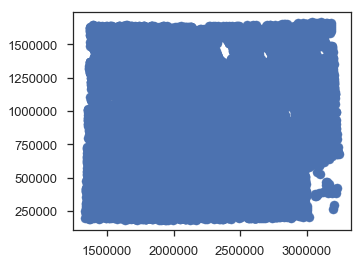

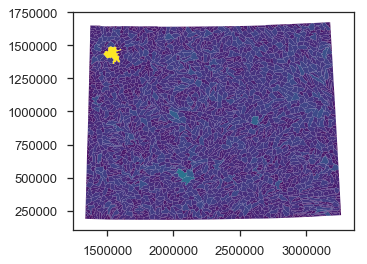

In [6]:
projGeoDF.plot()
huc8.plot(column='Shape_Area', cmap='viridis')
bedrock.plot(column ='Unit_Name')

In [14]:
bedrock.columns.values

array(['Symbol_Ori', 'Unit_Name', 'Unit_Descr', 'Unit_Age', 'Symbol',
       'RuleID_1', 'Shape_Leng', 'Shape_Area', 'geometry'], dtype=object)

In [5]:
points_with_basin=gpd.sjoin(projGeoDF, huc8, how='inner', op='intersects') #joins the points with the hydraulic basins

In [6]:
#what about basins with point data?
basins_with_points=gpd.sjoin(huc8,projGeoDF, how='inner', op='intersects') #joins the points with the hydraulic basins

In [36]:
basins_with_points.columns

Index(['AREA', 'PERIMETER', 'WY_HU12_', 'WY_HU12_ID', 'HUC_8', 'HUC_10',
       'HUC_12', 'ACRES', 'STATES', 'NCONTRB_A', 'HU_10_DS', 'HU_10_NAME',
       'HU_10_MOD', 'HU_10_TYPE', 'HU_12_DS', 'HU_12_NAME', 'HU_12_MOD',
       'HU_12_TYPE', 'HU_2_NAME', 'HU_4_NAME', 'HU_6_NAME', 'HU_8_NAME',
       'Shape_Leng', 'Shape_Area', 'geometry', 'area', 'index_right',
       'Unnamed: 0', 'u_dn_ppm', 'u_fl_ppm', 'ag_ppm', 'al_pct', 'as_ppm',
       'au_ppm', 'b_ppm', 'ba_ppm', 'be_ppm', 'bi_ppm', 'ca_pct', 'cd_ppm',
       'ce_ppm', 'cl_ppm', 'co_ppm', 'cr_ppm', 'cs_ppm', 'cu_ppm', 'dy_ppm',
       'eu_ppm', 'fe_pct', 'hf_ppm', 'k_pct', 'la_ppm', 'li_ppm', 'lu_ppm',
       'mg_pct', 'mn_ppm', 'mo_ppm', 'na_pct', 'nb_ppm', 'ni_ppm', 'p_ppm',
       'pb_ppm', 'rb_ppm', 'sb_ppm', 'sc_ppm', 'se_ppm', 'sm_ppm', 'sn_ppm',
       'sr_ppm', 'ta_ppm', 'tb_ppm', 'th_ppm', 'ti_ppm', 'v_ppm', 'w_ppm',
       'y_ppm', 'yb_ppm', 'zn_ppm', 'zr_ppm', 'longitude', 'latitude'],
      dtype='object')

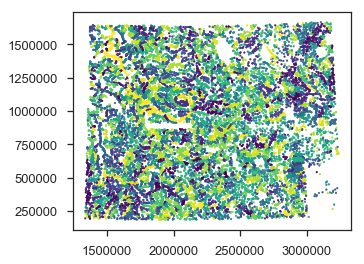

In [13]:
points_with_basin.plot('HU_12_NAME', s=3, cmap='viridis')

In [25]:
#reads in the basins with the percent of each formation per basin
basinFormations=pd.read_csv('J:/Geology/WSGS/Projects/Critical Minerals/basin_area_formation_huc12_percentage.csv', index_col='Unit_Name')

In [26]:
rotated=basinFormations.transpose() #reshape the matrix so that formations are columns
rotated['HU_12_NAME']=rotated.index

In [27]:
merged=points_with_basin.merge(rotated, on='HU_12_NAME') #merge the basins with percentage of formations with the points

In [101]:
merged.to_csv('J:/Geology/WSGS/hu_12_formations_points.csv') #points to file

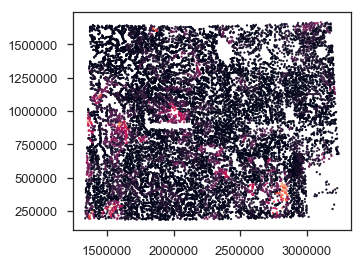

In [35]:
merged.plot('Alluvium and colluvium', s=3)

In [32]:
merged.columns.values

array(['Unnamed: 0', 'u_dn_ppm', 'u_fl_ppm', 'ag_ppm', 'al_pct', 'as_ppm',
       'au_ppm', 'b_ppm', 'ba_ppm', 'be_ppm', 'bi_ppm', 'ca_pct',
       'cd_ppm', 'ce_ppm', 'cl_ppm', 'co_ppm', 'cr_ppm', 'cs_ppm',
       'cu_ppm', 'dy_ppm', 'eu_ppm', 'fe_pct', 'hf_ppm', 'k_pct',
       'la_ppm', 'li_ppm', 'lu_ppm', 'mg_pct', 'mn_ppm', 'mo_ppm',
       'na_pct', 'nb_ppm', 'ni_ppm', 'p_ppm', 'pb_ppm', 'rb_ppm',
       'sb_ppm', 'sc_ppm', 'se_ppm', 'sm_ppm', 'sn_ppm', 'sr_ppm',
       'ta_ppm', 'tb_ppm', 'th_ppm', 'ti_ppm', 'v_ppm', 'w_ppm', 'y_ppm',
       'yb_ppm', 'zn_ppm', 'zr_ppm', 'longitude', 'latitude', 'geometry',
       'index_right', 'AREA', 'PERIMETER', 'WY_HU12_', 'WY_HU12_ID',
       'HUC_8', 'HUC_10', 'HUC_12', 'ACRES', 'STATES', 'NCONTRB_A',
       'HU_10_DS', 'HU_10_NAME', 'HU_10_MOD', 'HU_10_TYPE', 'HU_12_DS',
       'HU_12_NAME', 'HU_12_MOD', 'HU_12_TYPE', 'HU_2_NAME', 'HU_4_NAME',
       'HU_6_NAME', 'HU_8_NAME', 'Shape_Leng', 'Shape_Area', 'area',
       'Absaroka Volcanic 

In [163]:
hucProbability=pd.DataFrame({'huc':huc8.HUC_12.unique(), 'probability':huc8.area/huc8.area.sum()}) #probability of a choosing a huc at random spatially by area

In [164]:
area=[]
for i in bedrock.Unit_Name.unique():
    area.append(bedrock[bedrock['Unit_Name']==i].area.sum()/bedrock.area.sum())
formationProbability=pd.DataFrame({'formation':bedrock.Unit_Name.unique(), 'probability': area})


In [165]:
formationProbability.head()

,formation,probability
0,Mafic intrusive rocks,0.001082
1,"Ankareh Formation, Thaynes Limestone, Woodside...",0.002985
2,"Chugwater Formation (N, NE), or Chugwater Grou...",0.002690
3,Chugwater and Dinwoody Formations,0.004118
4,Chugwater and Goose Egg Formations,0.005766


In [166]:
reimport=pd.read_csv(r'J:\Geology\WSGS\Projects\Critical Minerals\hu_12_formations_points.csv')

C:\Users\jesse.pisel\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (70) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [167]:
len(reimport['HUC_12'].unique())

2175

In [169]:
hucProbability.unique().shape

AttributeError: 'DataFrame' object has no attribute 'unique'

In [7]:
bedrock[bedrock['Unit_Name']=='Meeteetse Formation']

,Symbol_Ori,Unit_Name,Unit_Descr,Unit_Age,Symbol,RuleID_1,Shape_Leng,Shape_Area,geometry
4087,Km,Meeteetse Formation,"Chalky-white to gray sandstone, yellow, green,...",Phanerozoic | Mesozoic | Cretaceous-Late,Km,108,0.009560,0.000004,"POLYGON ((1600231.799529599 1174282.95580375, ..."
4088,Km,Meeteetse Formation,"Chalky-white to gray sandstone, yellow, green,...",Phanerozoic | Mesozoic | Cretaceous-Late,Km,108,0.082780,0.000135,"POLYGON ((1596421.57725674 1175782.697224837, ..."
4089,Km,Meeteetse Formation,"Chalky-white to gray sandstone, yellow, green,...",Phanerozoic | Mesozoic | Cretaceous-Late,Km,108,1.076955,0.004015,"POLYGON ((2152757.141380633 1207435.653243054,..."
4090,Km,Meeteetse Formation,"Chalky-white to gray sandstone, yellow, green,...",Phanerozoic | Mesozoic | Cretaceous-Late,Km,108,0.012726,0.000009,"POLYGON ((1508360.04873902 1233894.140074537, ..."
4091,Km,Meeteetse Formation,"Chalky-white to gray sandstone, yellow, green,...",Phanerozoic | Mesozoic | Cretaceous-Late,Km,108,0.018589,0.000022,"POLYGON ((1505054.736395547 1234821.129121721,..."
4092,Km,Meeteetse Formation,"Chalky-white to gray sandstone, yellow, green,...",Phanerozoic | Mesozoic | Cretaceous-Late,Km,108,0.008555,0.000004,"POLYGON ((1508209.840431464 1235263.413526788,..."
4093,Km,Meeteetse Formation,"Chalky-white to gray sandstone, yellow, green,...",Phanerozoic | Mesozoic | Cretaceous-Late,Km,108,0.321685,0.002072,"POLYGON ((1927822.354163797 1305533.07540394, ..."
4094,Km,Meeteetse Formation,"Chalky-white to gray sandstone, yellow, green,...",Phanerozoic | Mesozoic | Cretaceous-Late,Km,108,0.561356,0.002752,"POLYGON ((1950661.311904101 1324028.534587472,..."
4095,Km,Meeteetse Formation,"Chalky-white to gray sandstone, yellow, green,...",Phanerozoic | Mesozoic | Cretaceous-Late,Km,108,0.189584,0.001474,"POLYGON ((1919398.091298201 1345876.986607042,..."
4096,Km,Meeteetse Formation,"Chalky-white to gray sandstone, yellow, green,...",Phanerozoic | Mesozoic | Cretaceous-Late,Km,108,0.390256,0.001807,"POLYGON ((1899981.314782809 1363749.021092882,..."
